In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import xgboost as xgb
from xgboost import XGBRegressor
import geopandas
from shapely.geometry import Point
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

pd.options.mode.chained_assignment = None

In [2]:
lacrime = pd.read_csv("Crime_Data_from_2010_to_Present.csv")

In [5]:
lacrime.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
0,1208575,03/14/2013,03/11/2013,1800,12,77th Street,1241,626,INTIMATE PARTNER - SIMPLE ASSAULT,0416 0446 1243 2000,...,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,626.0,NaN,NaN,NaN,6300 BRYNHURST AV,NaN,"(33.9829, -118.3338)"
1,102005556,01/25/2010,01/22/2010,2300,20,Olympic,2071,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,VAN NESS,15TH,"(34.0454, -118.3157)"
2,418,03/19/2013,03/18/2013,2030,18,Southeast,1823,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E 104TH ST,NaN,"(33.942, -118.2717)"
3,101822289,11/11/2010,11/10/2010,1800,18,Southeast,1803,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,88TH,WALL,"(33.9572, -118.2717)"
4,42104479,01/11/2014,01/04/2014,2300,21,Topanga,2133,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329,...,NaN,IC,Invest Cont,745.0,NaN,NaN,NaN,7200 CIRRUS WY,NaN,"(34.2009, -118.6369)"


## Find the zip codes for each incident given the latitude and longitude

In [6]:
lacrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1718433 entries, 0 to 1718432
Data columns (total 26 columns):
DR Number                 int64
Date Reported             object
Date Occurred             object
Time Occurred             int64
Area ID                   int64
Area Name                 object
Reporting District        int64
Crime Code                int64
Crime Code Description    object
MO Codes                  object
Victim Age                float64
Victim Sex                object
Victim Descent            object
Premise Code              float64
Premise Description       object
Weapon Used Code          float64
Weapon Description        object
Status Code               object
Status Description        object
Crime Code 1              float64
Crime Code 2              float64
Crime Code 3              float64
Crime Code 4              float64
Address                   object
Cross Street              object
Location                  object
dtypes: float64(7), int64(5

### change column names

In [3]:
lacrime = lacrime.rename(columns={'Area Name':'area_name', 'Reporting District':'reporting_district', 'Crime Code':'crime_code', 'Crime Code Description':'crime_code_desc', 'MO Codes':'mo_codes', 'Victim Age':'v_age', 'Victim Sex':'v_sex', 'Victim Descent':'v_descent'})

In [4]:
lacrime = lacrime.rename(columns={'Premise Code':'premise_code', 'Premise Description':'premise_desc', 'Weapon Used Code':'weapon_used_code', 'Weapon Description':'weapon_desc', 'Status Code':'status_code', 'Status Description':'status_desc', 'Cross Street':'cross_street'})

In [8]:
lacrime = lacrime.rename(columns={'DR Number':'number', 'Date Reported':'date_report', "Date Occurred":'date_occur','Time Occurred':'time','Area ID':'area_id','Location ':'location'})

In [9]:
lacrime.head()

,number,date_report,date_occur,time,area_id,area_name,reporting_district,crime_code,crime_code_desc,mo_codes,...,weapon_desc,status_code,status_desc,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,cross_street,location
0,1208575,03/14/2013,03/11/2013,1800,12,77th Street,1241,626,INTIMATE PARTNER - SIMPLE ASSAULT,0416 0446 1243 2000,...,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,626.0,NaN,NaN,NaN,6300 BRYNHURST AV,NaN,"(33.9829, -118.3338)"
1,102005556,01/25/2010,01/22/2010,2300,20,Olympic,2071,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,VAN NESS,15TH,"(34.0454, -118.3157)"
2,418,03/19/2013,03/18/2013,2030,18,Southeast,1823,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E 104TH ST,NaN,"(33.942, -118.2717)"
3,101822289,11/11/2010,11/10/2010,1800,18,Southeast,1803,510,VEHICLE - STOLEN,NaN,...,NaN,IC,Invest Cont,510.0,NaN,NaN,NaN,88TH,WALL,"(33.9572, -118.2717)"
4,42104479,01/11/2014,01/04/2014,2300,21,Topanga,2133,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329,...,NaN,IC,Invest Cont,745.0,NaN,NaN,NaN,7200 CIRRUS WY,NaN,"(34.2009, -118.6369)"


In [10]:
la_crime = lacrime.drop(['Crime Code 1', 'Crime Code 2', 'Crime Code 3', 'Crime Code 4'], axis=1)

In [16]:
la_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1718433 entries, 0 to 1718432
Data columns (total 22 columns):
dr_num                int64
date_reported         object
date_occured          object
time_occurred         int64
area_id               int64
area_name             object
reporting_district    int64
crime_code            int64
crime_code_desc       object
mo_codes              object
v_age                 float64
v_sex                 object
v_descent             object
premise_code          float64
premise_desc          object
weapon_used_code      float64
weapon_desc           object
status_code           object
status_desc           object
Address               object
cross_street          object
Location              object
dtypes: float64(3), int64(5), object(14)
memory usage: 288.4+ MB


In [21]:
la_crime['date_reported'] = pd.to_datetime(la_crime['date_reported'])

In [23]:
la_crime['date_reported']

0         2013-03-14
1         2010-01-25
2         2013-03-19
3         2010-11-11
4         2014-01-11
5         2013-01-08
6         2010-01-28
7         2010-11-11
8         2010-04-07
9         2013-03-29
10        2010-12-31
11        2010-10-26
12        2013-02-22
13        2013-06-20
14        2013-01-06
15        2013-01-02
16        2013-01-02
17        2013-01-02
18        2013-01-02
19        2013-01-05
20        2013-01-05
21        2013-01-05
22        2013-01-05
23        2013-01-15
24        2013-01-06
25        2013-01-09
26        2010-04-20
27        2013-01-12
28        2013-01-12
29        2013-01-12
             ...    
1718403   2018-04-04
1718404   2018-04-04
1718405   2018-04-04
1718406   2018-04-04
1718407   2018-04-04
1718408   2018-04-04
1718409   2018-04-03
1718410   2018-04-05
1718411   2018-04-04
1718412   2018-04-05
1718413   2018-04-05
1718414   2018-04-04
1718415   2018-04-05
1718416   2018-04-05
1718417   2018-04-05
1718418   2018-04-05
1718419   201

In [29]:
date.min()
date.max()
t_delta=(date-date.min()).astype('timedelta64[D]')
la_crime['days']=t_delta
la_crime.head(1)

,dr_num,date_reported,date_occured,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_desc,mo_codes,...,premise_code,premise_desc,weapon_used_code,weapon_desc,status_code,status_desc,Address,cross_street,Location,days
0,1208575,2013-03-14,03/11/2013,1800,12,77th Street,1241,626,INTIMATE PARTNER - SIMPLE ASSAULT,0416 0446 1243 2000,...,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,6300 BRYNHURST AV,NaN,"(33.9829, -118.3338)",1168.0


In [25]:
date = pd.to_datetime(la_crime['date_reported'])

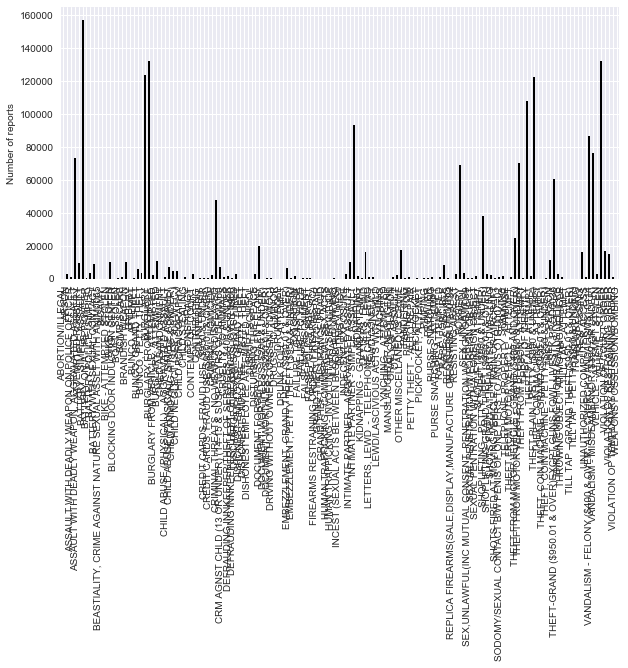

In [31]:
def plotdat(data,cat):
    l=data.groupby(cat).size()
    l.sort_values()
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=10,color='k')
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)

plotdat(la_crime,'crime_code_desc')

In [34]:
l=la_crime.groupby('crime_code_desc').size()
l.sort_values()
print(l.shape)

(142,)


In [92]:
def types_districts(la_crime,per):
    
    # Group by crime type and district 
    hoods_per_type=la_crime.groupby('crime_code_desc').area_name.value_counts(sort=True)
    t=hoods_per_type.unstack().fillna(0)
    
    # Sort by hood sum
    hood_sum=t.sum(axis=0)
    hood_sum.sort_values(ascending=False)
    t=t[hood_sum.index]
    
    # Filter by crime per district
    crime_sum=t.sum(axis=1)
    crime_sum.sort_values()
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t.loc[ix.index]
    return t
    
t=types_districts(la_crime,96)

/Users/kcdeleon/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


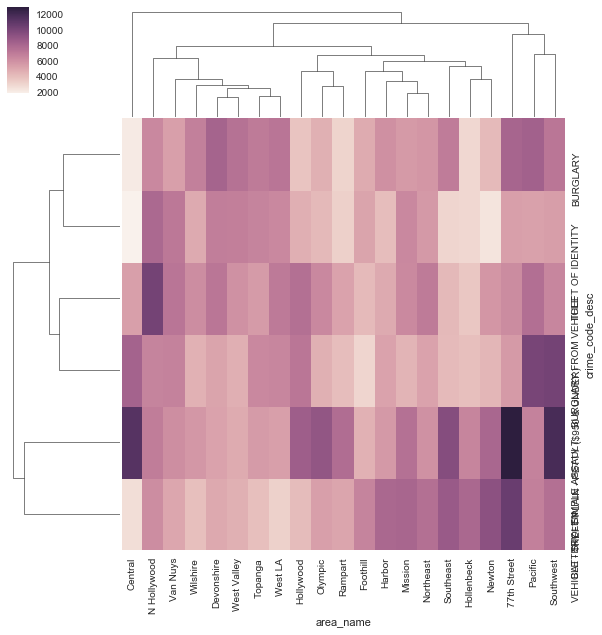

In [93]:
sns.clustermap(t)

##### The above normalizes the distribution across all districts

##### Let's say we want to track where in Los Angeles there are high rates of robbery

In [94]:
# drill down to arson
cat=la_crime[la_crime['crime_code_desc']=='ROBBERY']
c=cat['area_name'].value_counts()
c.sort_values(ascending=False)
c.head(10)

77th Street    8503
Southeast      6677
Southwest      6085
Newton         5776
Rampart        4612
Olympic        4371
Central        4019
Hollywood      3461
Mission        2586
Wilshire       2515
Name: area_name, dtype: int64

##### What if we want to know when these vandalism crimes usually take place?

In [95]:
# drill down to arson
cat=la_crime[la_crime['crime_code_desc']=='ROBBERY']
c=cat['time_occurred'].value_counts()
c.sort_values(ascending=False)
c.head(10)

2100    1140
2200    1140
2000    1071
1900    1045
1800    1033
2300    1021
1600    1002
1700     954
1500     921
2030     910
Name: time_occurred, dtype: int64

The left column is in military time. Most crimes are aggregating around the 1800 to 2300 range. This time, not suprisingly, is 6:00 pm to 11:00 pm. Robbery tends to be reported in the evenings.

In [96]:
t=types_districts(cat,70)

In [98]:
date.min()
date.max()
t_delta=(date-date.min()).astype('timedelta64[D]')
la_crime['days']=t_delta
la_crime.head(1)

,dr_num,date_reported,date_occured,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_desc,mo_codes,...,premise_code,premise_desc,weapon_used_code,weapon_desc,status_code,status_desc,Address,cross_street,Location,days
0,1208575,2013-03-14,03/11/2013,1800,12,77th Street,1241,626,INTIMATE PARTNER - SIMPLE ASSAULT,0416 0446 1243 2000,...,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,6300 BRYNHURST AV,NaN,"(33.9829, -118.3338)",1168.0


In [99]:
# Let's drill down onto one
cat=la_crime[la_crime['crime_code_desc']=='ROBBERY']

# Bin crime by 30 day window
cat['Month']=np.floor(cat['days']/30) # Approximate month (30 day window)

# Default
district='All'

In [100]:
date = pd.to_datetime(la_crime['date_reported'])

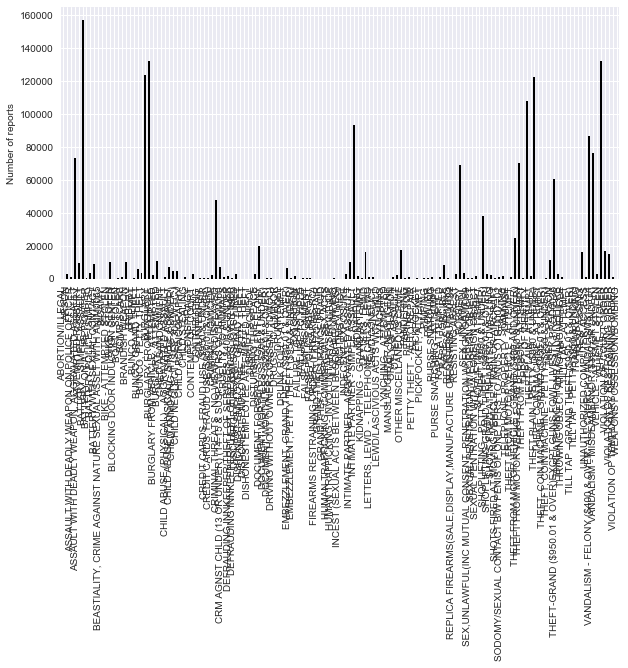

In [101]:
def plotdat(data,cat):
    l=data.groupby(cat).size()
    l.sort_values()
    fig=plt.figure(figsize=(10,5))
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=10,color='k')
    plt.xlabel('')
    plt.ylabel('Number of reports',fontsize=10)

plotdat(la_crime,'crime_code_desc')

In [102]:
def timeseries(dat,per):
    ''' Category grouped by month '''
    
    # Group by crime type and district 
    cat_per_time=dat.groupby('Month').crime_code_desc.value_counts(sort=True)
    t=cat_per_time.unstack().fillna(0)
        
    # Filter by crime per district
    crime_sum=t.sum(axis=0)
    crime_sum.sort_values()
    
    # Large number, so let's slice the data.
    p=np.percentile(crime_sum,per)
    ix=crime_sum[crime_sum>p]
    t=t[ix.index]
    return t
    
t_all=timeseries(cat,0)

In [103]:
la_crime = la_crime.rename(columns = {'Location ':'location'})

In [124]:
split_data = la_crime.location.str.strip(')').str.strip('(').str.split(', ')

In [126]:
la_crime['X'] = split_data.apply(lambda x: x[0])

TypeError: 'float' object is not subscriptable

In [117]:
la_crime['Y'] = split_data.apply(lambda x: x[1])

In [118]:
la_crime.head()

,dr_num,date_reported,date_occured,time_occurred,area_id,area_name,reporting_district,crime_code,crime_code_desc,mo_codes,...,weapon_used_code,weapon_desc,status_code,status_desc,Address,cross_street,location,days,X,Y
0,1208575,2013-03-14,03/11/2013,1800,12,77th Street,1241,626,INTIMATE PARTNER - SIMPLE ASSAULT,0416 0446 1243 2000,...,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,6300 BRYNHURST AV,NaN,"(33.9829, -118.3338)",1168.0,[,'
1,102005556,2010-01-25,01/22/2010,2300,20,Olympic,2071,510,VEHICLE - STOLEN,NaN,...,NaN,NaN,IC,Invest Cont,VAN NESS,15TH,"(34.0454, -118.3157)",24.0,[,'
2,418,2013-03-19,03/18/2013,2030,18,Southeast,1823,510,VEHICLE - STOLEN,NaN,...,NaN,NaN,IC,Invest Cont,200 E 104TH ST,NaN,"(33.942, -118.2717)",1173.0,[,'
3,101822289,2010-11-11,11/10/2010,1800,18,Southeast,1803,510,VEHICLE - STOLEN,NaN,...,NaN,NaN,IC,Invest Cont,88TH,WALL,"(33.9572, -118.2717)",314.0,[,'
4,42104479,2014-01-11,01/04/2014,2300,21,Topanga,2133,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329,...,NaN,NaN,IC,Invest Cont,7200 CIRRUS WY,NaN,"(34.2009, -118.6369)",1471.0,[,'


finding the area in Los Angeles with the highest crime:

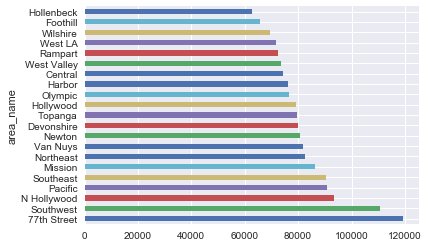

In [127]:
(     la_crime["area_name"]
     .groupby(la_crime["area_name"])
     .count()
     .sort_values(ascending=False)
     .plot(kind="barh")
)

Highest Crime rate in Los Angeles area from 2010-2017: 77th Street

status of crime reported

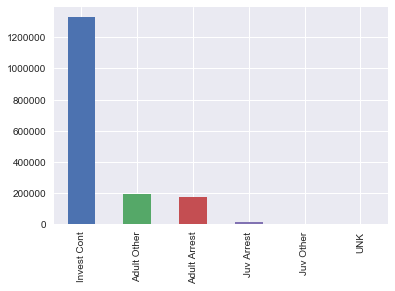

In [129]:
(
    la_crime["status_desc"]
    .value_counts()
    .plot(kind="bar")
)

#### Southwest division

In [130]:
Southwest = la_crime.set_index(['area_name']).loc['Southwest']
Southwest.head(5)

,dr_num,date_reported,date_occured,time_occurred,area_id,reporting_district,crime_code,crime_code_desc,mo_codes,v_age,...,weapon_used_code,weapon_desc,status_code,status_desc,Address,cross_street,location,days,X,Y
area_name,,,,,,,,,,,,,,,,,,,,,
Southwest,130322987,2013-10-27,10/26/2013,1800,3,396,510,VEHICLE - STOLEN,NaN,12.0,...,NaN,NaN,IC,Invest Cont,42ND,MENLO,"(34.0074, -118.29)",1395.0,[,'
Southwest,130325133,2013-12-01,11/30/2013,1800,3,394,510,VEHICLE - STOLEN,NaN,12.0,...,NaN,NaN,IC,Invest Cont,VERNON,3RD,"(34.0037, -118.3203)",1430.0,[,'
Southwest,130323518,2013-11-04,11/01/2013,1700,3,301,510,VEHICLE - STOLEN,NaN,12.0,...,NaN,NaN,IC,Invest Cont,CLYDE,ADAMS,"(34.0325, -118.3669)",1403.0,[,'
Southwest,130323846,2013-11-08,10/28/2013,1000,3,395,763,STALKING,0347 0913,50.0,...,NaN,NaN,IC,Invest Cont,VERNON,DENKER,"(34.0037, -118.3045)",1407.0,[,'
Southwest,130326498,2013-12-25,12/24/2013,2100,3,395,510,VEHICLE - STOLEN,NaN,12.0,...,NaN,NaN,IC,Invest Cont,43RD,GRAMERCY,"(34.0055, -118.3138)",1454.0,[,'


In [131]:
Southwest.groupby('area_id').size()

area_id
3    110810
dtype: int64

#### Count of different types of Crimes in Southwest of Los Angeles between 2010 - 2017

In [132]:
Southwest["date_reported"] = pd.to_datetime(Southwest["date_reported"])

In [133]:
pd.set_option('display.max_rows', 1000)
(    Southwest
     .groupby('crime_code_desc')
     .size()
     .head(25)
     .sort_values(ascending=False)
)

crime_code_desc
BATTERY - SIMPLE ASSAULT                                        11889
BURGLARY                                                         7370
BURGLARY FROM VEHICLE                                            6584
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT                   5966
BIKE - STOLEN                                                    1499
ATTEMPTED ROBBERY                                                 825
BRANDISH WEAPON                                                   778
BURGLARY, ATTEMPTED                                               758
BATTERY WITH SEXUAL CONTACT                                       609
BATTERY POLICE (SIMPLE)                                           279
ARSON                                                             207
BUNCO, GRAND THEFT                                                183
BURGLARY FROM VEHICLE, ATTEMPTED                                  156
BUNCO, PETTY THEFT                                                149
CHIL

Out of 110,810 crimes in the last 3 years, Traffic DR# and 'Battery - Simple Assault' are the top most crimes.

#### Ploting the graph for top 30 crimes in Southwest of Los Angeles

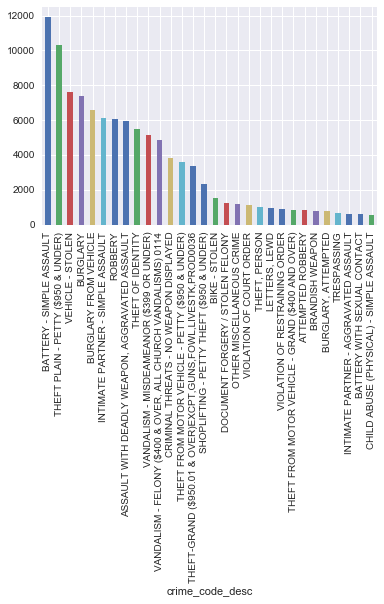

In [134]:
(
    Southwest
    .groupby('crime_code_desc')
    .size()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind="bar")
)

### Crimes reported in Southwest area each year

#### Between 2016 - 2017

In [136]:
import numpy

In [138]:
(Southwest[(Southwest['date_reported']>="2016-01-01") & 
          (Southwest['date_reported']<"2018-01-01")] 
         .groupby(["crime_code_desc"])         
         .agg({'crime_code_desc':numpy.size})
         .head(25)
         .sort_values(["crime_code_desc"],ascending=False)         
)

,crime_code_desc
crime_code_desc,
BATTERY - SIMPLE ASSAULT,2396
"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1749
BURGLARY FROM VEHICLE,1665
BURGLARY,1543
BIKE - STOLEN,1058
BRANDISH WEAPON,402
ATTEMPTED ROBBERY,227
BATTERY WITH SEXUAL CONTACT,153
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,135


#### Number of incidents reported between 2016 to 2017

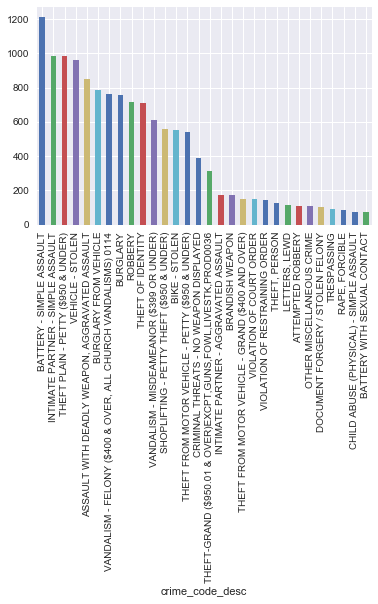

In [140]:
(Southwest[(Southwest['date_reported']>="2016-01-01") & 
          (Southwest['date_reported']<"2017-01-01")] 
        .groupby('crime_code_desc')
        .size()
        .sort_values(ascending=False)
        .head(30)
        .plot(kind="bar"))

#### Number of incidents reported between 2015 - 2016

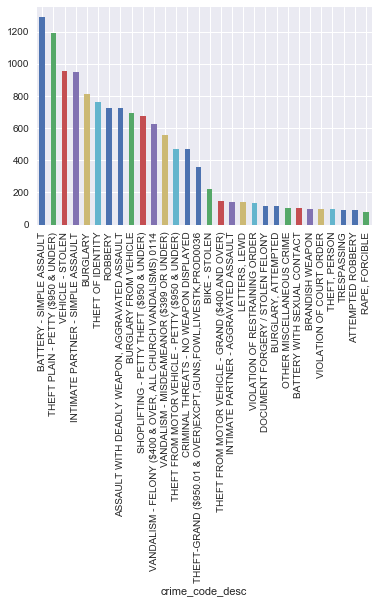

In [142]:
(Southwest[(Southwest['date_reported']>="2015-01-01") & 
          (Southwest['date_reported']<"2016-01-01")] 
        .groupby('crime_code_desc')
        .size()
        .sort_values(ascending=False)
        .head(30)
        .plot(kind="bar"))

#### Status of crimes reported between 2016 - 2017

In [144]:
(Southwest[(Southwest['date_reported']>="2016-01-01") & 
          (Southwest['date_reported']<"2017-01-01")] 
         .groupby(["status_desc"])         
         .agg({'status_desc':numpy.size})
         .sort_values(["status_desc"],ascending=False)
         
)

,status_desc
status_desc,
Invest Cont,10690
Adult Other,2110
Adult Arrest,1235
Juv Arrest,181
Juv Other,48
UNK,1


#### The given data does not provide track a crime from reported to completed status. Hence this data gives a snapshot only during reporting.

Now let's explore the crimes reported in Streets of Southwest area between 2016 - 2017 (This is even more interesting)

In [147]:
(Southwest[(Southwest['date_reported']>="2016-01-01") & 
          (Southwest['date_reported']<"2017-01-01")] 
         .groupby(["Address"])         
         .agg({'Address':numpy.size})         
         .sort_values(["Address"],ascending=False)
         .head(25)
         
)

,Address
Address,
3500 S LA CIENEGA BL,233
3700 SANTA ROSALIA DR,147
CRENSHAW BL,108
MARTIN LUTHER KING JR BL,107
4000 CRENSHAW BL,98
3600 W MARTIN LUTHER KING JR BL,95
3300 S FIGUEROA ST,79
ADAMS BL,77
5000 RODEO RD,76


In [148]:
(Southwest[(Southwest['date_reported']>="2016-01-01") & 
          (Southwest['date_reported']<"2017-01-01")] 
         .groupby(["Address","crime_code_desc"])         
         .agg({'Address':numpy.size})         
         .sort_values(["Address"],ascending=False)
         .head(25)
)

,,Address
Address,crime_code_desc,
3500 S LA CIENEGA BL,SHOPLIFTING - PETTY THEFT ($950 & UNDER),171
3700 SANTA ROSALIA DR,SHOPLIFTING - PETTY THEFT ($950 & UNDER),110
4000 CRENSHAW BL,SHOPLIFTING - PETTY THEFT ($950 & UNDER),59
3400 S LA CIENEGA BL,BURGLARY,49
3600 W MARTIN LUTHER KING JR BL,SHOPLIFTING - PETTY THEFT ($950 & UNDER),36
3500 TROUSDALE PY,BIKE - STOLEN,29
MARTIN LUTHER KING JR BL,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",26
CRENSHAW BL,ROBBERY,23
S WESTERN AV,ROBBERY,21


#### Traffic DR#, Robbery, Theft are the top happening crimes around USC/Downtown.

[<matplotlib.text.Text at 0x297a8e898>, <matplotlib.text.Text at 0x297ce1c88>]

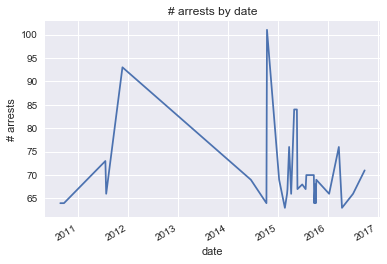

In [149]:
(Southwest
        .groupby('date_reported')
        .size()
        .sort_values(ascending=False)
        .head(30)
        .plot(title="# arrests by date")
        .set(xlabel = "date",ylabel = "# arrests")
)

## Find the zip codes for each incident given the latitude and longitude

In [11]:
location = la_crime['location'].str[1:-1].str.split(',', expand=True).astype(float)

In [12]:
la_crime.head()

,number,date_report,date_occur,time,area_id,area_name,reporting_district,crime_code,crime_code_desc,mo_codes,...,v_descent,premise_code,premise_desc,weapon_used_code,weapon_desc,status_code,status_desc,Address,cross_street,location
0,1208575,03/14/2013,03/11/2013,1800,12,77th Street,1241,626,INTIMATE PARTNER - SIMPLE ASSAULT,0416 0446 1243 2000,...,W,502.0,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,6300 BRYNHURST AV,NaN,"(33.9829, -118.3338)"
1,102005556,01/25/2010,01/22/2010,2300,20,Olympic,2071,510,VEHICLE - STOLEN,NaN,...,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,VAN NESS,15TH,"(34.0454, -118.3157)"
2,418,03/19/2013,03/18/2013,2030,18,Southeast,1823,510,VEHICLE - STOLEN,NaN,...,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,200 E 104TH ST,NaN,"(33.942, -118.2717)"
3,101822289,11/11/2010,11/10/2010,1800,18,Southeast,1803,510,VEHICLE - STOLEN,NaN,...,NaN,101.0,STREET,NaN,NaN,IC,Invest Cont,88TH,WALL,"(33.9572, -118.2717)"
4,42104479,01/11/2014,01/04/2014,2300,21,Topanga,2133,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329,...,W,501.0,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,7200 CIRRUS WY,NaN,"(34.2009, -118.6369)"


In [13]:
location.columns = ['Y', 'X']

In [14]:
location.head()

,Y,X
0,33.9829,-118.3338
1,34.0454,-118.3157
2,33.9420,-118.2717
3,33.9572,-118.2717
4,34.2009,-118.6369


In [15]:
crime_la = la_crime.join(location, on=None)

In [16]:
crime_la.head()

,number,date_report,date_occur,time,area_id,area_name,reporting_district,crime_code,crime_code_desc,mo_codes,...,premise_desc,weapon_used_code,weapon_desc,status_code,status_desc,Address,cross_street,location,Y,X
0,1208575,03/14/2013,03/11/2013,1800,12,77th Street,1241,626,INTIMATE PARTNER - SIMPLE ASSAULT,0416 0446 1243 2000,...,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AO,Adult Other,6300 BRYNHURST AV,NaN,"(33.9829, -118.3338)",33.9829,-118.3338
1,102005556,01/25/2010,01/22/2010,2300,20,Olympic,2071,510,VEHICLE - STOLEN,NaN,...,STREET,NaN,NaN,IC,Invest Cont,VAN NESS,15TH,"(34.0454, -118.3157)",34.0454,-118.3157
2,418,03/19/2013,03/18/2013,2030,18,Southeast,1823,510,VEHICLE - STOLEN,NaN,...,STREET,NaN,NaN,IC,Invest Cont,200 E 104TH ST,NaN,"(33.942, -118.2717)",33.9420,-118.2717
3,101822289,11/11/2010,11/10/2010,1800,18,Southeast,1803,510,VEHICLE - STOLEN,NaN,...,STREET,NaN,NaN,IC,Invest Cont,88TH,WALL,"(33.9572, -118.2717)",33.9572,-118.2717
4,42104479,01/11/2014,01/04/2014,2300,21,Topanga,2133,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329,...,SINGLE FAMILY DWELLING,NaN,NaN,IC,Invest Cont,7200 CIRRUS WY,NaN,"(34.2009, -118.6369)",34.2009,-118.6369


In [19]:
crime_la['date_occur'] = pd.to_datetime(crime_la['date_occur'])

In [20]:
crime_13 = (crime_la['date_occur'] >= '2013-01-01') & (crime_la['date_occur'] <= '2013-12-31')

In [21]:
mask = (crime_la['date_occur'] >= '2016-01-01') & (crime_la['date_occur'] <= '2016-12-31')

In [22]:
mask.head()

0    False
1    False
2    False
3    False
4    False
Name: date_occur, dtype: bool

### Extract 2016 Data

In [23]:
crime_16 = crime_la.loc[mask]

In [24]:
crime_16.head()

,number,date_report,date_occur,time,area_id,area_name,reporting_district,crime_code,crime_code_desc,mo_codes,...,premise_desc,weapon_used_code,weapon_desc,status_code,status_desc,Address,cross_street,location,Y,X
1145301,160118253,07/04/2016,2016-07-04,1,1,Central,192,510,VEHICLE - STOLEN,NaN,...,STREET,NaN,NaN,IC,Invest Cont,VENICE,HOPE,"(34.0365, -118.2676)",34.0365,-118.2676
1145402,160119435,07/21/2016,2016-07-21,1330,1,Central,134,888,TRESPASSING,2004,...,MARKET,NaN,NaN,IC,Invest Cont,300 S BROADWAY,NaN,"(34.051, -118.248)",34.0510,-118.2480
1145404,160107159,02/09/2016,2016-02-08,2040,1,Central,185,762,LEWD CONDUCT,0340 0528,...,SIDEWALK,NaN,NaN,IC,Invest Cont,HILL,PICO,"(34.0377, -118.2621)",34.0377,-118.2621
1145424,160204906,01/19/2016,2016-01-17,1900,2,Rampart,249,510,VEHICLE - STOLEN,NaN,...,STREET,NaN,NaN,IC,Invest Cont,BIXEL,3RD,"(34.0576, -118.2598)",34.0576,-118.2598
1145544,160213291,07/03/2016,2016-07-02,1800,2,Rampart,248,510,VEHICLE - STOLEN,NaN,...,STREET,NaN,NaN,IC,Invest Cont,LUCAS,MARYLAND,"(34.0557, -118.2632)",34.0557,-118.2632


### Extract 2017 data

In [25]:
mask17 = (crime_la['date_occur'] >= '2017-01-01') & (crime_la['date_occur'] <= '2017-12-31')

In [28]:
crime_17 = crime_la.loc[mask17]

In [29]:
crime_17.head()

,number,date_report,date_occur,time,area_id,area_name,reporting_district,crime_code,crime_code_desc,mo_codes,...,premise_desc,weapon_used_code,weapon_desc,status_code,status_desc,Address,cross_street,location,Y,X
657856,171013348,07/21/2017,2017-07-20,2000,10,West Valley,1047,330,BURGLARY FROM VEHICLE,1609 0344,...,NaN,NaN,NaN,IC,Invest Cont,00,NaN,NaN,NaN,NaN
734870,171013326,07/21/2017,2017-07-21,1000,10,West Valley,1008,330,BURGLARY FROM VEHICLE,1609 0344 0377,...,NaN,NaN,NaN,IC,Invest Cont,00,NaN,NaN,NaN,NaN
1310783,170209449,04/22/2017,2017-04-21,1930,2,Rampart,201,510,VEHICLE - STOLEN,NaN,...,STREET,NaN,NaN,IC,Invest Cont,ALEXANDRIA,ROMAINE,"(34.0886, -118.2979)",34.0886,-118.2979
1384743,170206243,02/14/2017,2017-02-11,1700,2,Rampart,275,510,VEHICLE - STOLEN,NaN,...,STREET,NaN,NaN,IC,Invest Cont,OLYMPIC,WESTLAKE,"(34.0512, -118.2787)",34.0512,-118.2787
1385314,170311599,04/25/2017,2017-04-25,745,3,Southwest,325,510,VEHICLE - STOLEN,NaN,...,STREET,NaN,NaN,IC,Invest Cont,VERMONT,ADAMS,"(34.0328, -118.2915)",34.0328,-118.2915


### Find the zip codes for each incident given the latitude and longitude

In [31]:
crime_16['geometry'] = crime_16.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [32]:
geo_police_data = geopandas.GeoDataFrame(crime_16, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}

In [33]:
la = geopandas.read_file('zip_code_la.json')
la.crs = {'init': 'epsg:4326'}
la = la.set_geometry('geometry')

In [34]:
crime16 = geopandas.tools.sjoin(geo_police_data, la, how='left')

### Find which zip codes, day of week, and hour have the most crimes

In [36]:
crime16['day_of_week'] = crime16['date_occur'].dt.weekday_name

In [38]:
crime16['time'] = crime16.time.astype(int)

In [48]:
day_time_zip_16 = crime16[['day_of_week', 'date_occur', 'time', 'ZIPCODE']]

In [40]:
day_time_zip_16.loc[:, 'Date'] = pd.to_datetime(day_time_zip_16['date_occur'])

In [50]:
day_time_zip_16.loc[:, 'Date'] = pd.to_datetime(day_time_zip_16['date_occur'])

In [51]:
day_time_zip_16['time'] = pd.to_datetime(day_time_zip_16['time'], format='%H%M', errors='coerce')

In [53]:
day_time_zip_16['time'] = pd.DatetimeIndex(day_time_zip_16['time']).time

In [55]:
day_time_zip_16[['hour','min','s']] = day_time_zip_16['time'].astype(str).str.split(':', expand=True)

In [56]:
day_time_zip_16.head()

,day_of_week,date_occur,time,ZIPCODE,Date,hour,min,s
1145301,Monday,2016-07-04,NaN,90015,2016-07-04,nan,None,None
1145402,Thursday,2016-07-21,13:30:00,90013,2016-07-21,13,30,00
1145404,Monday,2016-02-08,20:40:00,90015,2016-02-08,20,40,00
1145424,Sunday,2016-01-17,19:00:00,90017,2016-01-17,19,00,00
1145544,Saturday,2016-07-02,18:00:00,90017,2016-07-02,18,00,00


In [58]:
day_time_zip_16.drop(columns=['s', 'date_occur', 'min'])

,day_of_week,time,ZIPCODE,Date,hour
1145301,Monday,NaN,90015,2016-07-04,nan
1145402,Thursday,13:30:00,90013,2016-07-21,13
1145404,Monday,20:40:00,90015,2016-02-08,20
1145424,Sunday,19:00:00,90017,2016-01-17,19
1145544,Saturday,18:00:00,90017,2016-07-02,18
1145564,Sunday,16:00:00,90026,2016-02-21,16
1145686,Thursday,23:30:00,90057,2016-02-25,23
1145866,Thursday,NaN,90015,2016-04-14,nan
1145908,Thursday,12:40:00,90026,2016-07-14,12
1146109,Monday,14:30:00,90015,2016-08-08,14


### Combine all the crimes into hours and days and zip codes

In [59]:
day_time_zip_16_final = day_time_zip_16[['day_of_week', 'ZIPCODE', 'hour']]

In [60]:
day_time_zip_16_final.loc[:, 'Crimes'] = 1

In [61]:
hour_totals_16 = day_time_zip_16_final.groupby(['day_of_week', 'ZIPCODE', 'hour']).sum().reset_index()

In [62]:
hour_totals_16.sort_values('Crimes', ascending = False).head()

,day_of_week,ZIPCODE,hour,Crimes
5854,Saturday,90028,23,111
7929,Sunday,90003,20,87
5307,Saturday,90003,20,83
13119,Tuesday,90003,20,83
6182,Saturday,90044,20,82


### Create dummy variables to start doing analysis

In [63]:
hour_totals_16 = hour_totals_16[['Crimes', 'hour', 'day_of_week', 'ZIPCODE']]

In [64]:
totals_dummies_16 = pd.get_dummies(hour_totals_16)

In [65]:
totals_dummies_16.head()

,Crimes,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,...,ZIPCODE_91504,ZIPCODE_91505,ZIPCODE_91601,ZIPCODE_91602,ZIPCODE_91604,ZIPCODE_91605,ZIPCODE_91606,ZIPCODE_91607,ZIPCODE_91608,ZIPCODE_91801
0,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
X_16 = totals_dummies_16.iloc[:, 1:]
y_16 = totals_dummies_16.iloc[:, 0]

### Linear Regression with subset data

In [67]:
linear_regression = sm.OLS(y_16, X_16)
results = linear_regression.fit()

In [68]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Crimes   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     331.8
Date:                Sun, 15 Apr 2018   Prob (F-statistic):               0.00
Time:                        20:51:35   Log-Likelihood:                -56343.
No. Observations:               18249   AIC:                         1.130e+05
Df Residuals:                   18081   BIC:                         1.143e+05
Df Model:                         167                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
hour_01                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_02                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_03                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_04                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_05                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_06                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_07                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_08                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_09                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_10                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_11                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_12                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_13                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_14                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_15                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_16                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_17                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_18                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_19                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_20                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_21                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_22                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_23                1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
hour_nan               1.162e+13   6.26e+12      1.858      0.063   -6.38e+11    2.39e+13
day_of_week_Friday    -2.841e+11   4.21e+12     -0.067      0.946   -8.55e+12    7.98e+12
day_of_week_Monday    -2.841e+11   4.21e+12     -0.067      0.946   -8.55e+12    7.98e+12
day_of_week_Saturday  -2.841e+11   4.21e+12     -0.067      0.946   -8.55e+12    7.98e+12
day_of_week_Sunday    -2.841e+11   4.21e+12     -0.067      0.946   -8.55e+12    7.98e+12
day_of_week_Thursday  -2.841e+11   4.21e+12     -0.067      0.946   -8.55e+12    7.98e+12
day_of_week_Tuesday   -2.841e+11   4.21e+12     -0.067      0.946   -8.55e+12    7.98e+12
day_of_week_Wednesday -2.841e+11   4.21e+12     -0.067      0.946   -8.55e+12    7.98e+12
ZIPCODE_90001         -

# Test it with newer data

### Find the zip codes for each incident given the latitude and longitude

In [70]:
crime_17['geometry'] = crime_17.apply(lambda row: Point(row['X'], row['Y']), axis=1)

In [71]:
geo_police_data = geopandas.GeoDataFrame(crime_17, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}

In [72]:
la = geopandas.read_file('zip_code_la.json')
la.crs = {'init': 'epsg:4326'}
la = la.set_geometry('geometry')

In [75]:
crime_17 = crime_17.dropna(subset=['Y','X'], how='any',axis=0) 

In [77]:
geo_police_data = geopandas.GeoDataFrame(crime_17, geometry='geometry')
geo_police_data.crs = {'init': 'epsg:4326'}

In [78]:
crime17 = geopandas.tools.sjoin(geo_police_data, la, how='left')

## Find which zip codes, day of week, and hour have the most crimes

In [79]:
crime17['day_of_week'] = crime17['date_occur'].dt.weekday_name

In [80]:
day_time_zip_17 = crime17[['day_of_week', 'time', 'ZIPCODE']]

In [81]:
day_time_zip_17['time'] = day_time_zip_17.time.astype(int)

In [85]:
day_time_zip_17['time'] = pd.to_datetime(day_time_zip_17['time'], format='%H%M', errors='coerce')

In [87]:
day_time_zip_17['time'] = pd.DatetimeIndex(day_time_zip_17['time']).time

In [88]:
day_time_zip_17.head()

,day_of_week,time,ZIPCODE,time_occur
1310783,Friday,19:30:00,90029,00:00:00.000001
1384743,Saturday,17:00:00,90006,00:00:00.000001
1385314,Tuesday,07:45:00,90007,00:00:00
1385596,Friday,NaN,90031,00:00:00
1385692,Saturday,07:30:00,90731,00:00:00


In [89]:
day_time_zip_17.drop(columns=['time_occur'])

,day_of_week,time,ZIPCODE
1310783,Friday,19:30:00,90029
1384743,Saturday,17:00:00,90006
1385314,Tuesday,07:45:00,90007
1385596,Friday,NaN,90031
1385692,Saturday,07:30:00,90731
1386020,Monday,23:00:00,90036
1386710,Thursday,17:00:00,90013
1386773,Tuesday,20:30:00,90013
1387042,Thursday,10:00:00,90023
1387111,Friday,03:00:00,90026


In [91]:
day_time_zip_17[['hour','min','s']] = day_time_zip_17['time'].astype(str).str.split(':', expand=True)

In [92]:
day_time_zip_17.head()

,day_of_week,time,ZIPCODE,time_occur,Date,hour,min,s
1310783,Friday,19:30:00,90029,00:00:00.000001,NaT,19,30,00
1384743,Saturday,17:00:00,90006,00:00:00.000001,NaT,17,00,00
1385314,Tuesday,07:45:00,90007,00:00:00,NaT,07,45,00
1385596,Friday,NaN,90031,00:00:00,NaT,nan,None,None
1385692,Saturday,07:30:00,90731,00:00:00,NaT,07,30,00


In [93]:
day_time_zip_17.drop(columns=['s', 'Date', 'time_occur', 'min'])

,day_of_week,time,ZIPCODE,hour
1310783,Friday,19:30:00,90029,19
1384743,Saturday,17:00:00,90006,17
1385314,Tuesday,07:45:00,90007,07
1385596,Friday,NaN,90031,nan
1385692,Saturday,07:30:00,90731,07
1386020,Monday,23:00:00,90036,23
1386710,Thursday,17:00:00,90013,17
1386773,Tuesday,20:30:00,90013,20
1387042,Thursday,10:00:00,90023,10
1387111,Friday,03:00:00,90026,03


### Combine all the crimes into hours and days and zip codes

In [94]:
day_time_zip_17 = day_time_zip_17[['day_of_week', 'ZIPCODE', 'hour']]

In [95]:
day_time_zip_17['Crimes'] = 1

In [96]:
hour_totals_17 = day_time_zip_17.groupby(['day_of_week', 'ZIPCODE', 'hour']).count().reset_index()

In [97]:
hour_totals_17.sort_values('Crimes', ascending = False).head()

,day_of_week,ZIPCODE,hour,Crimes
8477,Sunday,90028,20,87
7932,Sunday,90003,20,84
5313,Saturday,90003,20,84
5858,Saturday,90028,23,82
5856,Saturday,90028,21,81


## Create dummy variables to start doing analysis

In [98]:
hour_totals_17 = hour_totals_17[['Crimes', 'hour', 'day_of_week', 'ZIPCODE']]

In [99]:
totals_dummies_17 = pd.get_dummies(hour_totals_17)

In [100]:
X_17 = totals_dummies_17.iloc[:, 1:]
y_17 = totals_dummies_17.iloc[:, 0]

# Testing the different models

### Linear Regression

In [101]:
linear_regression = LinearRegression()
linear_regression.fit(X_16,y_16)
linear_regression.score(X_17, y_17)

0.5941492313797982

### Random Forest

In [102]:
rf = RandomForestRegressor()
rf.fit(X_16, y_16)
rf.score(X_17,y_17)

0.6745943477858674

In [103]:
list(zip(X_16.columns, rf.feature_importances_))

[('hour_01', 0.0320284760284211),
 ('hour_02', 0.03149148221345598),
 ('hour_03', 0.017866169702398196),
 ('hour_04', 0.023462585537298266),
 ('hour_05', 0.026147793397224665),
 ('hour_06', 0.025044843808286598),
 ('hour_07', 0.019133078118454702),
 ('hour_08', 0.009333245481487463),
 ('hour_09', 0.012398697677281943),
 ('hour_10', 0.004643014855013079),
 ('hour_11', 0.006933440303671251),
 ('hour_12', 0.02889006355724657),
 ('hour_13', 0.004658315474725569),
 ('hour_14', 0.004458635615805069),
 ('hour_15', 0.0046157998809488),
 ('hour_16', 0.004534614794265155),
 ('hour_17', 0.004796895324055284),
 ('hour_18', 0.007574369303513085),
 ('hour_19', 0.005641918896359052),
 ('hour_20', 0.02340845509654625),
 ('hour_21', 0.006384445955670115),
 ('hour_22', 0.006581995067033638),
 ('hour_23', 0.007030239776336962),
 ('hour_nan', 0.0213120410967354),
 ('day_of_week_Friday', 0.01087329027392321),
 ('day_of_week_Monday', 0.009252083289085876),
 ('day_of_week_Saturday', 0.011592451933472029),
 (

### KNN

In [104]:
knn = KNeighborsRegressor()
knn.fit(X_16, y_16)
knn.score(X_17,y_17)

0.45272031306976457

### SVM - support vector machine

In [106]:
svm = SVR()
svm.fit(X_16, y_16)
svm.score(X_17,y_17)

0.19982395340698422

### XGBoost

In [107]:
xgb = XGBRegressor()
xgb.fit(X_16, y_16)
xgb.score(X_17,y_17)

ValueError: feature_names mismatch: ['hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_nan', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'ZIPCODE_90001', 'ZIPCODE_90002', 'ZIPCODE_90003', 'ZIPCODE_90004', 'ZIPCODE_90005', 'ZIPCODE_90006', 'ZIPCODE_90007', 'ZIPCODE_90008', 'ZIPCODE_90010', 'ZIPCODE_90011', 'ZIPCODE_90012', 'ZIPCODE_90013', 'ZIPCODE_90014', 'ZIPCODE_90015', 'ZIPCODE_90016', 'ZIPCODE_90017', 'ZIPCODE_90018', 'ZIPCODE_90019', 'ZIPCODE_90020', 'ZIPCODE_90021', 'ZIPCODE_90023', 'ZIPCODE_90024', 'ZIPCODE_90025', 'ZIPCODE_90026', 'ZIPCODE_90027', 'ZIPCODE_90028', 'ZIPCODE_90029', 'ZIPCODE_90031', 'ZIPCODE_90032', 'ZIPCODE_90033', 'ZIPCODE_90034', 'ZIPCODE_90035', 'ZIPCODE_90036', 'ZIPCODE_90037', 'ZIPCODE_90038', 'ZIPCODE_90039', 'ZIPCODE_90041', 'ZIPCODE_90042', 'ZIPCODE_90043', 'ZIPCODE_90044', 'ZIPCODE_90045', 'ZIPCODE_90046', 'ZIPCODE_90047', 'ZIPCODE_90048', 'ZIPCODE_90049', 'ZIPCODE_90056', 'ZIPCODE_90057', 'ZIPCODE_90058', 'ZIPCODE_90059', 'ZIPCODE_90061', 'ZIPCODE_90062', 'ZIPCODE_90063', 'ZIPCODE_90064', 'ZIPCODE_90065', 'ZIPCODE_90066', 'ZIPCODE_90067', 'ZIPCODE_90068', 'ZIPCODE_90069', 'ZIPCODE_90071', 'ZIPCODE_90073', 'ZIPCODE_90077', 'ZIPCODE_90089', 'ZIPCODE_90094', 'ZIPCODE_90095', 'ZIPCODE_90210', 'ZIPCODE_90211', 'ZIPCODE_90230', 'ZIPCODE_90232', 'ZIPCODE_90245', 'ZIPCODE_90247', 'ZIPCODE_90248', 'ZIPCODE_90272', 'ZIPCODE_90275', 'ZIPCODE_90291', 'ZIPCODE_90292', 'ZIPCODE_90293', 'ZIPCODE_90301', 'ZIPCODE_90302', 'ZIPCODE_90304', 'ZIPCODE_90305', 'ZIPCODE_90402', 'ZIPCODE_90404', 'ZIPCODE_90405', 'ZIPCODE_90501', 'ZIPCODE_90502', 'ZIPCODE_90710', 'ZIPCODE_90717', 'ZIPCODE_90731', 'ZIPCODE_90732', 'ZIPCODE_90744', 'ZIPCODE_90745', 'ZIPCODE_90810', 'ZIPCODE_91040', 'ZIPCODE_91042', 'ZIPCODE_91105', 'ZIPCODE_91204', 'ZIPCODE_91205', 'ZIPCODE_91214', 'ZIPCODE_91302', 'ZIPCODE_91303', 'ZIPCODE_91304', 'ZIPCODE_91306', 'ZIPCODE_91307', 'ZIPCODE_91311', 'ZIPCODE_91316', 'ZIPCODE_91321', 'ZIPCODE_91324', 'ZIPCODE_91325', 'ZIPCODE_91326', 'ZIPCODE_91330', 'ZIPCODE_91331', 'ZIPCODE_91335', 'ZIPCODE_91340', 'ZIPCODE_91342', 'ZIPCODE_91343', 'ZIPCODE_91344', 'ZIPCODE_91345', 'ZIPCODE_91352', 'ZIPCODE_91356', 'ZIPCODE_91364', 'ZIPCODE_91367', 'ZIPCODE_91401', 'ZIPCODE_91402', 'ZIPCODE_91403', 'ZIPCODE_91405', 'ZIPCODE_91406', 'ZIPCODE_91411', 'ZIPCODE_91423', 'ZIPCODE_91436', 'ZIPCODE_91504', 'ZIPCODE_91505', 'ZIPCODE_91601', 'ZIPCODE_91602', 'ZIPCODE_91604', 'ZIPCODE_91605', 'ZIPCODE_91606', 'ZIPCODE_91607', 'ZIPCODE_91608', 'ZIPCODE_91801'] ['hour_01', 'hour_02', 'hour_03', 'hour_04', 'hour_05', 'hour_06', 'hour_07', 'hour_08', 'hour_09', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'hour_nan', 'day_of_week_Friday', 'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday', 'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday', 'ZIPCODE_90001', 'ZIPCODE_90002', 'ZIPCODE_90003', 'ZIPCODE_90004', 'ZIPCODE_90005', 'ZIPCODE_90006', 'ZIPCODE_90007', 'ZIPCODE_90008', 'ZIPCODE_90010', 'ZIPCODE_90011', 'ZIPCODE_90012', 'ZIPCODE_90013', 'ZIPCODE_90014', 'ZIPCODE_90015', 'ZIPCODE_90016', 'ZIPCODE_90017', 'ZIPCODE_90018', 'ZIPCODE_90019', 'ZIPCODE_90020', 'ZIPCODE_90021', 'ZIPCODE_90023', 'ZIPCODE_90024', 'ZIPCODE_90025', 'ZIPCODE_90026', 'ZIPCODE_90027', 'ZIPCODE_90028', 'ZIPCODE_90029', 'ZIPCODE_90031', 'ZIPCODE_90032', 'ZIPCODE_90033', 'ZIPCODE_90034', 'ZIPCODE_90035', 'ZIPCODE_90036', 'ZIPCODE_90037', 'ZIPCODE_90038', 'ZIPCODE_90039', 'ZIPCODE_90041', 'ZIPCODE_90042', 'ZIPCODE_90043', 'ZIPCODE_90044', 'ZIPCODE_90045', 'ZIPCODE_90046', 'ZIPCODE_90047', 'ZIPCODE_90048', 'ZIPCODE_90049', 'ZIPCODE_90056', 'ZIPCODE_90057', 'ZIPCODE_90058', 'ZIPCODE_90059', 'ZIPCODE_90061', 'ZIPCODE_90062', 'ZIPCODE_90063', 'ZIPCODE_90064', 'ZIPCODE_90065', 'ZIPCODE_90066', 'ZIPCODE_90067', 'ZIPCODE_90068', 'ZIPCODE_90069', 'ZIPCODE_90071', 'ZIPCODE_90073', 'ZIPCODE_90077', 'ZIPCODE_90089', 'ZIPCODE_90094', 'ZIPCODE_90095', 'ZIPCODE_90210', 'ZIPCODE_90211', 'ZIPCODE_90212', 'ZIPCODE_90230', 'ZIPCODE_90232', 'ZIPCODE_90245', 'ZIPCODE_90247', 'ZIPCODE_90248', 'ZIPCODE_90262', 'ZIPCODE_90272', 'ZIPCODE_90275', 'ZIPCODE_90280', 'ZIPCODE_90291', 'ZIPCODE_90292', 'ZIPCODE_90293', 'ZIPCODE_90301', 'ZIPCODE_90302', 'ZIPCODE_90304', 'ZIPCODE_90305', 'ZIPCODE_90402', 'ZIPCODE_90404', 'ZIPCODE_90405', 'ZIPCODE_90501', 'ZIPCODE_90502', 'ZIPCODE_90710', 'ZIPCODE_90717', 'ZIPCODE_90731', 'ZIPCODE_90732', 'ZIPCODE_90744', 'ZIPCODE_90745', 'ZIPCODE_90810', 'ZIPCODE_91040', 'ZIPCODE_91042', 'ZIPCODE_91201', 'ZIPCODE_91205', 'ZIPCODE_91214', 'ZIPCODE_91303', 'ZIPCODE_91304', 'ZIPCODE_91306', 'ZIPCODE_91307', 'ZIPCODE_91311', 'ZIPCODE_91316', 'ZIPCODE_91324', 'ZIPCODE_91325', 'ZIPCODE_91326', 'ZIPCODE_91330', 'ZIPCODE_91331', 'ZIPCODE_91335', 'ZIPCODE_91340', 'ZIPCODE_91342', 'ZIPCODE_91343', 'ZIPCODE_91344', 'ZIPCODE_91345', 'ZIPCODE_91352', 'ZIPCODE_91356', 'ZIPCODE_91364', 'ZIPCODE_91367', 'ZIPCODE_91401', 'ZIPCODE_91402', 'ZIPCODE_91403', 'ZIPCODE_91405', 'ZIPCODE_91406', 'ZIPCODE_91411', 'ZIPCODE_91423', 'ZIPCODE_91436', 'ZIPCODE_91504', 'ZIPCODE_91505', 'ZIPCODE_91601', 'ZIPCODE_91602', 'ZIPCODE_91604', 'ZIPCODE_91605', 'ZIPCODE_91606', 'ZIPCODE_91607', 'ZIPCODE_91608', 'ZIPCODE_91801']
expected ZIPCODE_91105, ZIPCODE_91321, ZIPCODE_91204, ZIPCODE_91302 in input data
training data did not have the following fields: ZIPCODE_91201, ZIPCODE_90280, ZIPCODE_90262, ZIPCODE_90212

### MLP Regressor

In [108]:
mlp = MLPRegressor(hidden_layer_sizes = (100,100,100,100), random_state=444)
mlp.fit(X_16,y_16)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=444,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [109]:
mlp.score(X_17, y_17)

0.6370738470958923

## Combine predictions and actual results into one dataframe

In [110]:
mlp_predicts = mlp.predict(X_16)

In [111]:
xgb_predicts = xgb.predict(X_16)

In [112]:
hour_totals_17['Predicted_mlp'] = pd.Series(mlp_predicts)
hour_totals_17['Predicted_xgb'] = pd.Series(xgb_predicts)

### Divide by 365 to get the number of crime incidents each day

In [113]:
hour_totals_17['Crimes'] = hour_totals_17['Crimes']/365
hour_totals_17['Predicted_mlp'] = hour_totals_17['Predicted_mlp']/365
hour_totals_17['Predicted_xgb'] = hour_totals_17['Predicted_xgb']/365

In [114]:
hour_totals_17 = np.round(hour_totals_17,2)

In [115]:
hour_totals_17.to_json("crime_predictions.json", orient='records', double_precision=2)

## Create a quick Chloropleth map as a sanity check

In [116]:
chloropleth_data = hour_totals_17.merge(la)
chloropleth_data = geopandas.GeoDataFrame(chloropleth_data, geometry='geometry')
chloropleth_data.crs = {'init': 'epsg:4326'}

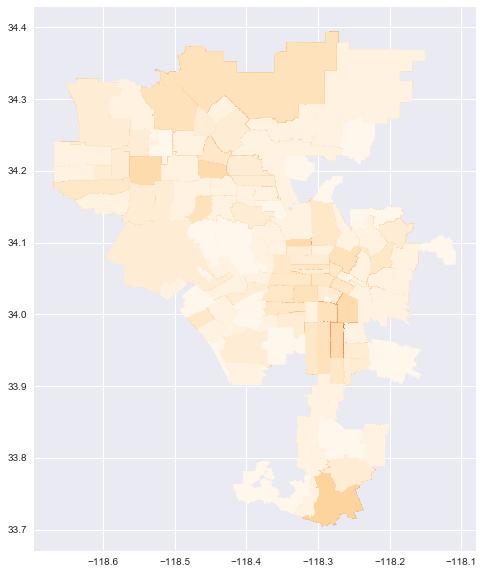

In [117]:
chloropleth_data.plot(column='Crimes', cmap='OrRd', figsize=(13,10))

The next step is to make an interactive visualization. For this, I will move to D3.js